# SRCNN Paper Reproduction

In [1]:
import tensorflow as tf

flags

In [2]:
flags = tf.compat.v1.flags
flags.DEFINE_integer("epoch", 1000, "Number of epoch [1000]")
flags.DEFINE_integer("batch_size", 128, "The size of batch images [128]")
flags.DEFINE_integer("image_size", 33, "The size of image to use [33]")
flags.DEFINE_integer("label_size", 21, "The size of label to produce [21]")
flags.DEFINE_float("learning_rate", 1e-4, "The learning rate of gradient descent algorithm [1e-4]")
flags.DEFINE_integer("c_dim", 1, "Dimension of image color. [1]")
flags.DEFINE_integer("scale", 3, "The size of scale factor for preprocessing input image [3]")
flags.DEFINE_integer("stride", 14, "The size of stride to apply input image [14]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Name of checkpoint directory [checkpoint]")
flags.DEFINE_string("sample_dir", "sample", "Name of sample directory [sample]")
flags.DEFINE_string("train_dir", "Train", "Name of training set directory")
flags.DEFINE_boolean("is_train", True, "True for training, False for testing [True]")
FLAGS = flags.FLAGS

In [3]:
import os
import glob
import sys
sys.argv = sys.argv[:1]
data_dir = os.path.join(os.getcwd(), FLAGS.train_dir)
# print(data_dir)
data = glob.glob(os.path.join(data_dir, "*.bmp"))
# print(data)

pre-processing

In [4]:
import imageio

# def prepare_data(sess, dataset):
#     """
#       Args:
#         dataset: choose train dataset or test dataset
    
#         For train dataset, output data would be ['.../t1.bmp', '.../t2.bmp', ..., '.../t99.bmp']
#     """
#     if FLAGS.is_train:
#         filenames = os.listdir(dataset)
#         data_dir = os.path.join(os.getcwd(), dataset)
#         data = glob.glob(os.path.join(data_dir, "*.bmp"))
#     else:
#         data_dir = os.path.join(os.sep, (os.path.join(os.getcwd(), dataset)), "Set5")
#         data = glob.glob(os.path.join(data_dir, "*.bmp"))

#     return data

In [5]:
# read *.bmp files
def read_data(path, is_grayscale=True):
    if is_grayscale:
        return imageio.imread(path, as_gray=True, pilmode='YCbCr').astype(np.float)
    else:
        return imageio.imread(path, pilmode='YCbCr').astype(np.float)    

In [6]:
def modcrop(image, scale=3):
    '''
    To scale down and up the original img, first thing to do is to have no remainder while scaling operation
    '''
    if len(image.shape)==3:
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:   
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image    

In [7]:
import scipy.misc
def preprocess(path, scale=3):   
    """
      Preprocess single image file 
        (1) Read original image as YCbCr format (and grayscale as default)
        (2) Normalize
        (3) Apply image file with bicubic interpolation
      Args:
        path: file path of desired file
        input_: image applied bicubic interpolation (low-resolution)
        label_: image with original resolution (high-resolution) 
    """
    image = read_data(path, is_grayscale=True)
    label_ = modcrop(image, scale)

  # Must be normalized
    image = image / 255.
    label_ = label_ / 255.


    input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
      # so that bicubic is applied
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)

    return input_, label_

Display input and groundtruth

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

91
(288, 411)
(288, 411)


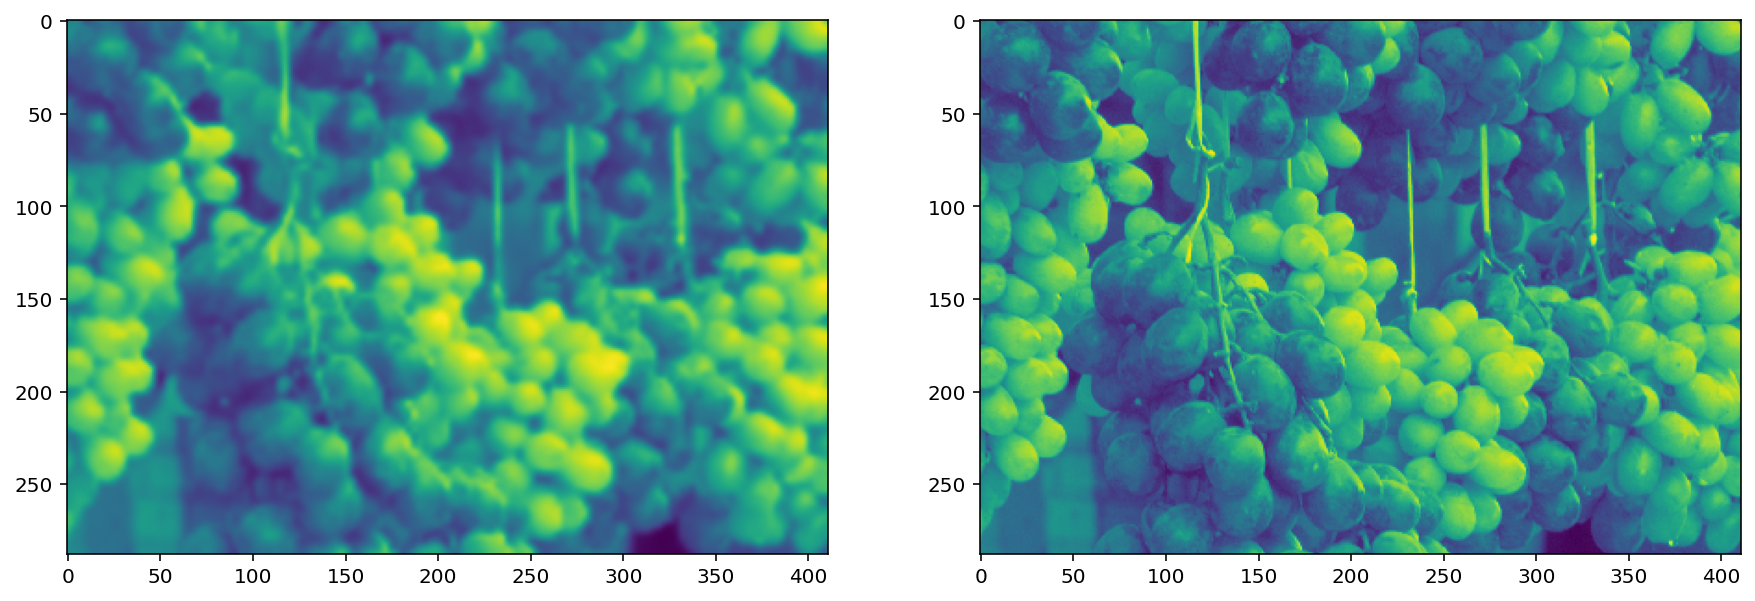

In [9]:
import numpy as np
print(len(data))
input_, label_ = preprocess(data[0], FLAGS.scale)
plt.figure(figsize=(15,15))
for i, image in enumerate([input_, label_]):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    print(image.shape)

Read image files and make their sub-image and save 

In [10]:
sub_input_sequence = []
sub_label_sequence = []
padding = int(abs(FLAGS.image_size - FLAGS.label_size)/2)
for i in range(len(data)):
    if i%10 == 0:
        input_, label_ = preprocess(data[i], FLAGS.scale)
        if len(input_.shape) == 3:
            h, w, _ = input_.shape
        else:
            h, w = input_.shape
        for x in range(0, h-FLAGS.image_size+1, FLAGS.stride):
            for y in range(0, w-FLAGS.image_size+1, FLAGS.stride):
                sub_input = input_[x:x+FLAGS.image_size, y:y+FLAGS.image_size] # 31*31
                sub_label = label_[x+padding:x+padding+FLAGS.label_size, y+padding:y+padding+FLAGS.label_size] # 21*21
                
                # Add Channel Value
                sub_input = sub_input.reshape([FLAGS.image_size, FLAGS.image_size, 1])
                sub_label = sub_label.reshape([FLAGS.label_size, FLAGS.label_size, 1])
                sub_input_sequence.append(sub_input)
                sub_label_sequence.append(sub_label)

In [11]:
"""
the number of sub_input (33*33*ch) in one img
"""
len(sub_input_sequence)
len(sub_label_sequence)

2736

In [12]:
"""
Make list to numpy array
"""
arrdata = np.asarray(sub_input_sequence)
arrlabel = np.asarray(sub_label_sequence)

In [13]:
arrdata.shape

(2736, 33, 33, 1)

In [14]:
import h5py
"""
Make input data as h5 file format
"""
if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
savepath = os.path.join(os.getcwd(), FLAGS.checkpoint_dir, 'train.h5')    
with h5py.File(savepath, 'w') as hf:
    hf.create_dataset('data', data=arrdata)
    hf.create_dataset('label', data=arrlabel)

# checkpoint
The preprocessed data has been saved to disk, 
and we get the data use the following method.

In [15]:
data_dir = os.path.join('./{}'.format('checkpoint'), "train.h5")

def get_data(path):
    with h5py.File(path, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        return data, label
train_data, train_label = get_data(data_dir)    

# Build the network

In [19]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

"""
Inputs:
"""
images = tf.placeholder(tf.float32,[None, FLAGS.image_size, FLAGS.image_size, FLAGS.c_dim], name='images')
labels = tf.placeholder(tf.float32, [None, FLAGS.label_size, FLAGS.label_size, FLAGS.c_dim], name='labels')

"""
Weights and Biases
"""
weights={
    'w1': tf.Variable(tf.random_normal([9,9,1,64], stddev=1e-3), name='w1'),
    'w2': tf.Variable(tf.random_normal([1,1,64,32], stddev=1e-3), name='w2'),
    'w3': tf.Variable(tf.random_normal([5,5,32,1], stddev=1e-3), name='w3')
}
biases={
    'b1': tf.Variable(tf.zeros([64]), name='b1'),
    'b2': tf.Variable(tf.zeros([32]), name='b2'),
    'b3': tf.Variable(tf.zeros([1]), name='b3')
}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
